In [1]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import math
import pandas as pd
from torch import nn

In [2]:
import rasterio

# open the raster dataset
ds = rasterio.open("landuse.tif")

# get the longitude and latitude of the point
lon, lat = ds.xy(55, 3999)

print(f"The longitude and latitude of the random point ({lon}, {lat}).")
# print the bounding box of the dataset
print(ds.bounds)

The longitude and latitude of the random point (-87.7107655089372, 42.084790733276655).
BoundingBox(left=-88.12076525987973, bottom=41.68042918368474, right=-87.60820150073167, top=42.090480191003195)


In [71]:
# img = rasterio.open('FloodSusceptibilityIndex_3.tif')
landuse = rasterio.open("landuse.tif")
riverine_index = rasterio.open("riverine_index.tif")
BFE = rasterio.open("BFE.tif")
flood_index = rasterio.open("flood_index.tif")

In [72]:
landuse = np.mean(landuse.read(), axis=0)
riverine_index = np.mean(riverine_index.read(), axis=0)
BFE = np.mean(BFE.read(), axis=0)
flood_index = np.mean(flood_index.read(), axis=0)

In [73]:
# preprocessing
flood_index = flood_index.astype(np.float32)
flood_index = 255 - flood_index
flood_index = flood_index / 255

unique_values = np.unique(flood_index)
print(unique_values)

[0.         0.07973854 0.15032677 0.22091502 0.29281047 0.3633987
 0.43660128 0.5071896  0.57908493 0.64836603 0.7176471 ]


In [6]:
# get flood_index[0,0] datatype
print(flood_index.dtype)

float32


In [89]:
BFE = 255 - BFE

In [86]:
banduse = 255 - landuse
banduse = banduse / 255

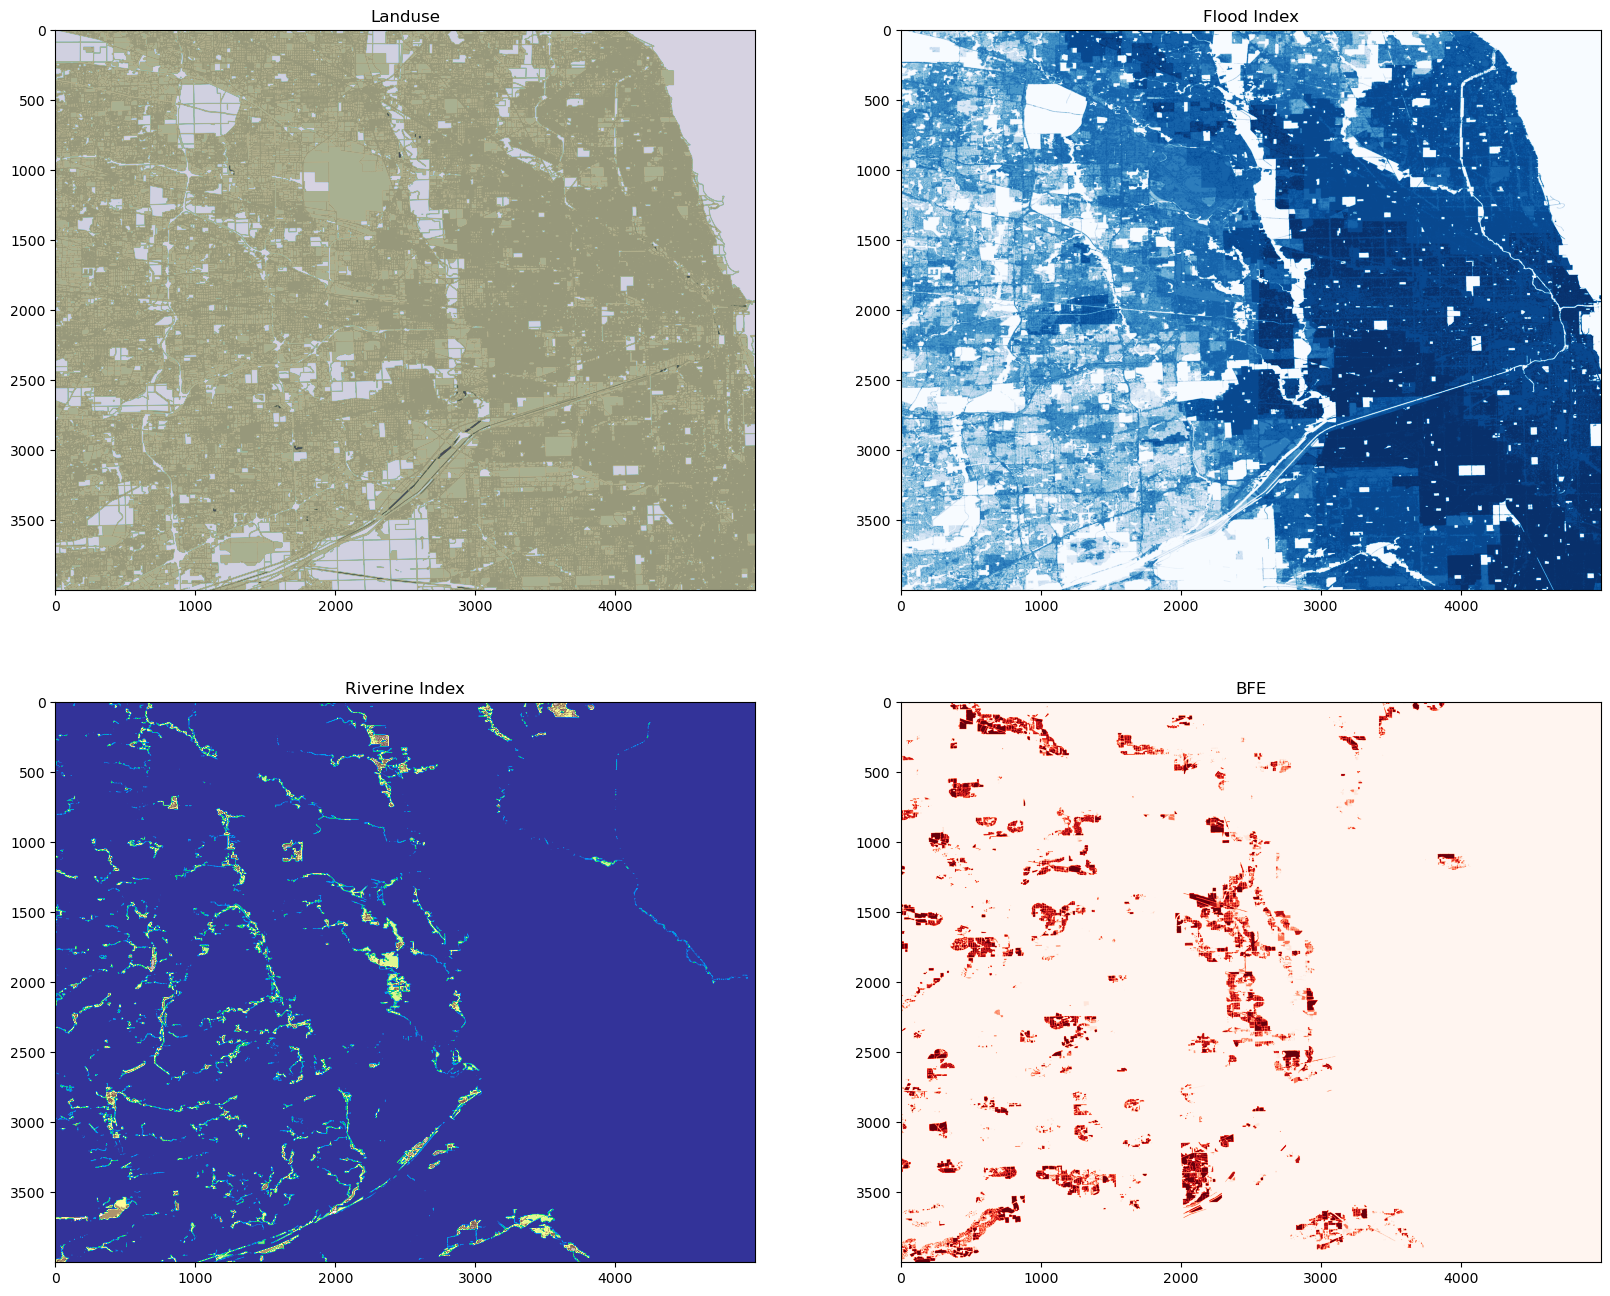

In [90]:
# plot the single channel
# get axis object with 5 rows and 1 column
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes[0][0].imshow(landuse, cmap="copper", alpha=0.5)
axes[0][0].imshow(landuse, cmap="terrain", alpha=0.5)
axes[0][0].imshow(landuse, cmap="gray", alpha=0.7)
axes[0][0].imshow(banduse, cmap="terrain", alpha=0.2)
axes[0][0].set_title("Landuse")

axes[0][1].imshow(flood_index, cmap="Blues")
axes[0][1].set_title("Flood Index")
axes[1][0].imshow(riverine_index, cmap="terrain")
axes[1][0].set_title("Riverine Index")
axes[1][1].imshow(BFE, cmap="Reds")
axes[1][1].set_title("BFE")
plt.show()

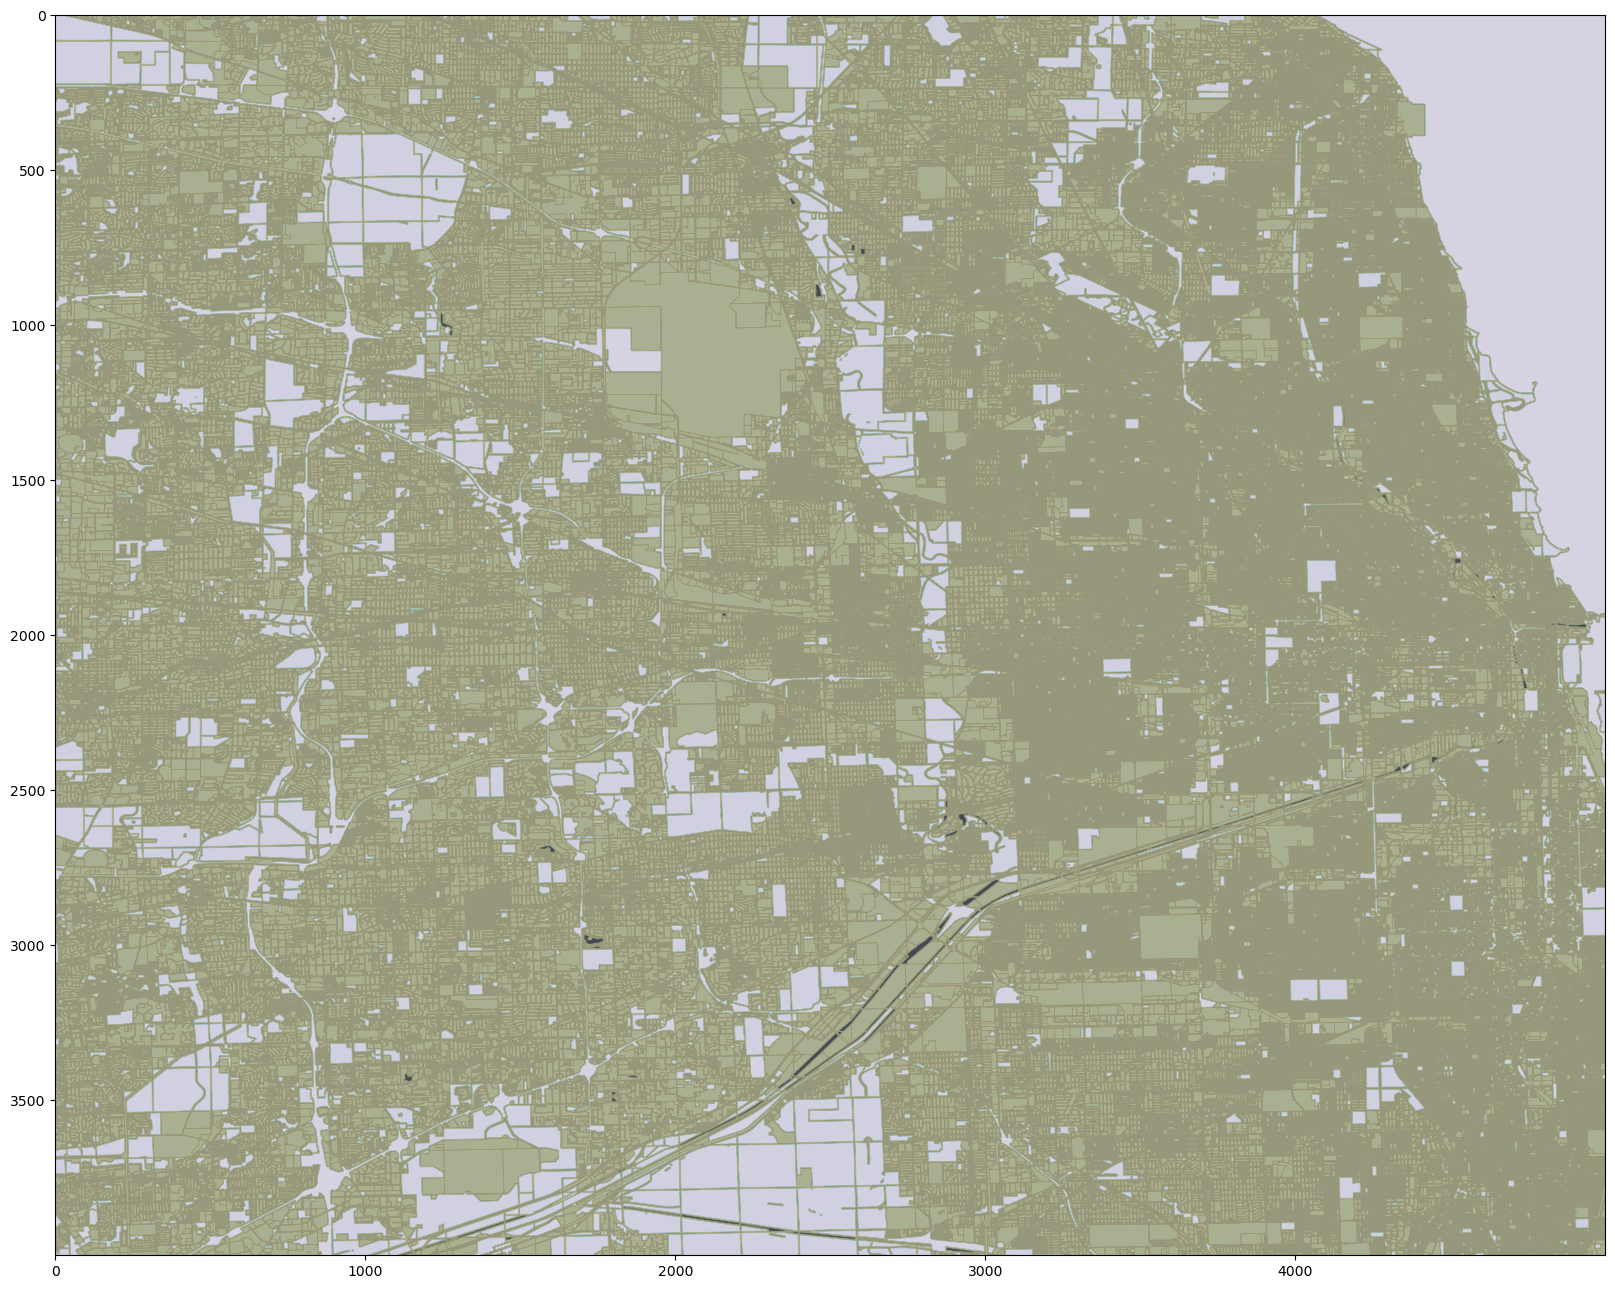

In [85]:
# plt.imshow(landuse, cmap='Greens', alpha=0.2)
# set figure size
plt.figure(figsize=(20, 20))
plt.imshow(landuse, cmap="copper", alpha=0.5)
plt.imshow(landuse, cmap="terrain", alpha=0.5)
plt.imshow(landuse, cmap="gray", alpha=0.7)
plt.imshow(banduse, cmap="terrain", alpha=0.2)

In [128]:
landuse = 255 - landuse

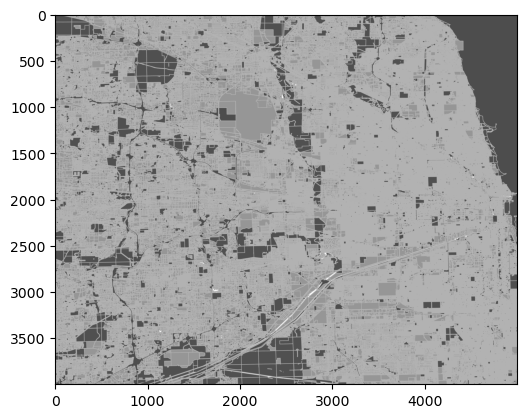

In [129]:
plt.imshow(landuse, cmap="gray", alpha=0.7)

In [130]:
print("landuse shape:", landuse.shape)
print("riverine_index shape:", riverine_index.shape)
print("BFE shape:", BFE.shape)
print("flood_index shape:", flood_index.shape)

landuse shape: (4000, 5000)
riverine_index shape: (4000, 5000)
BFE shape: (4000, 5000)
flood_index shape: (4000, 5000)


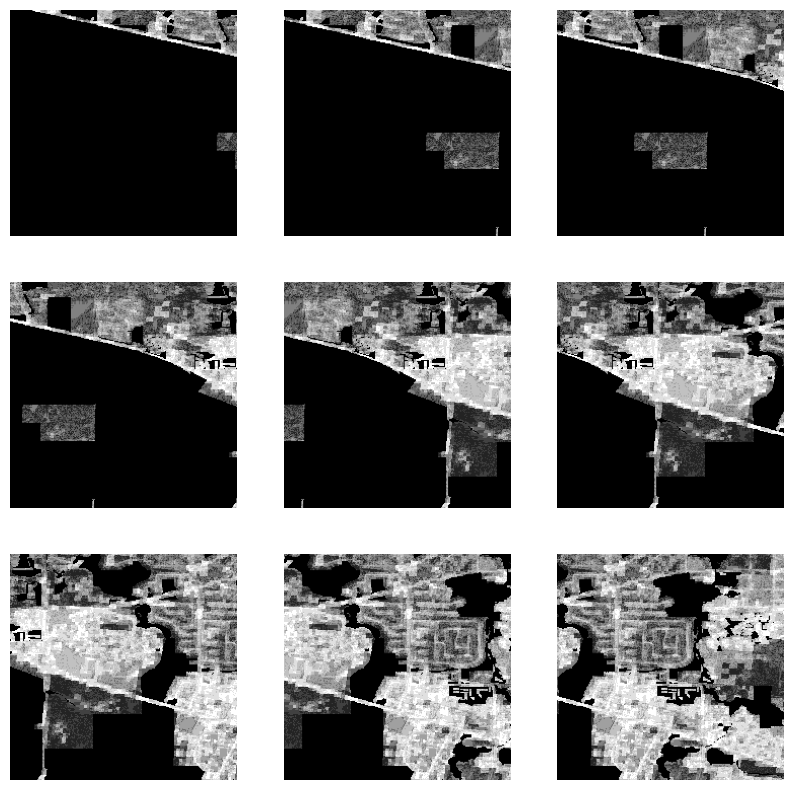

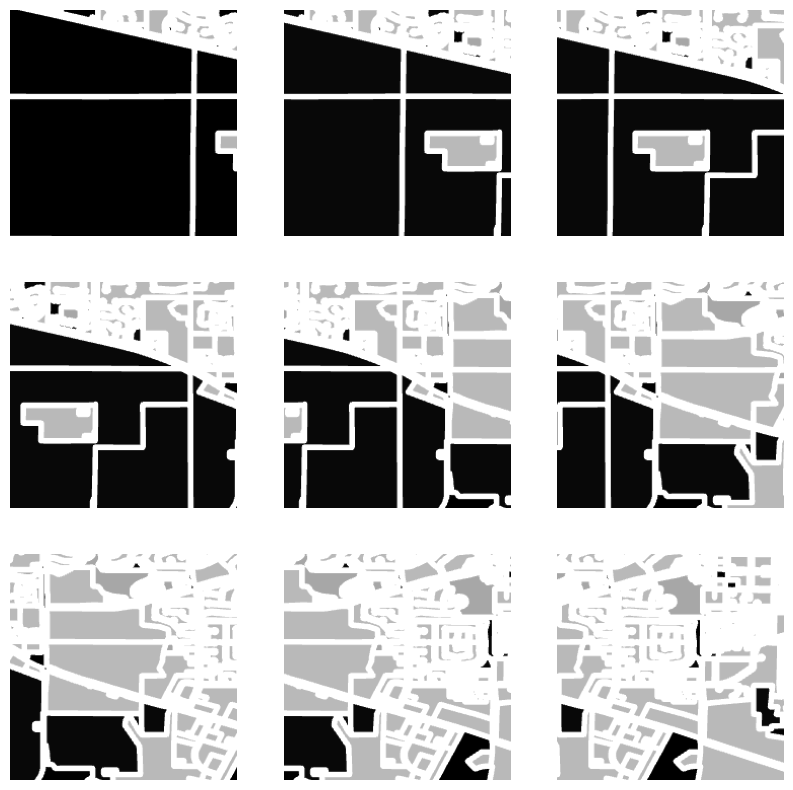

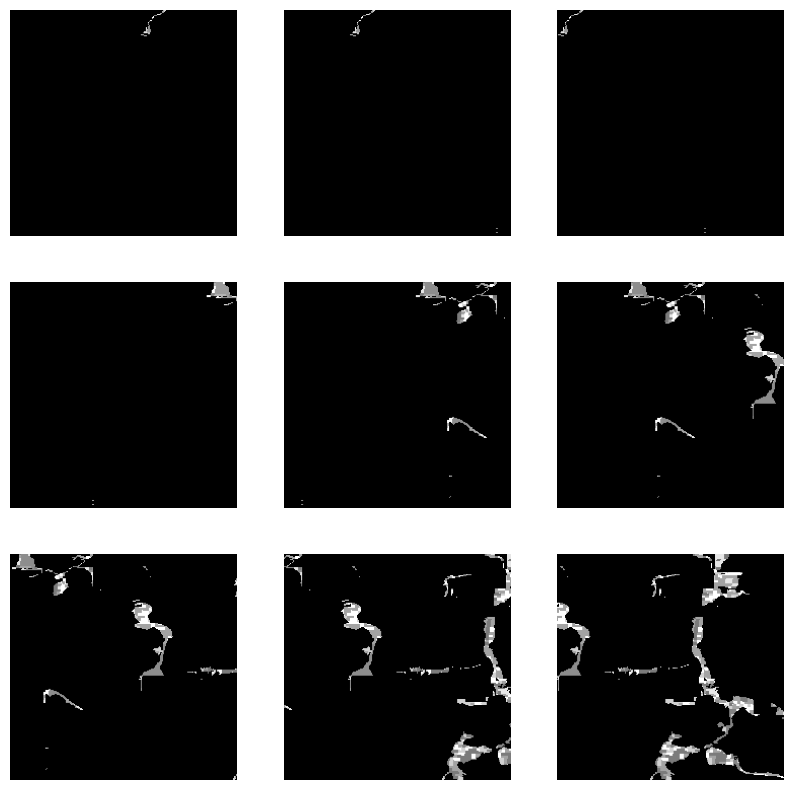

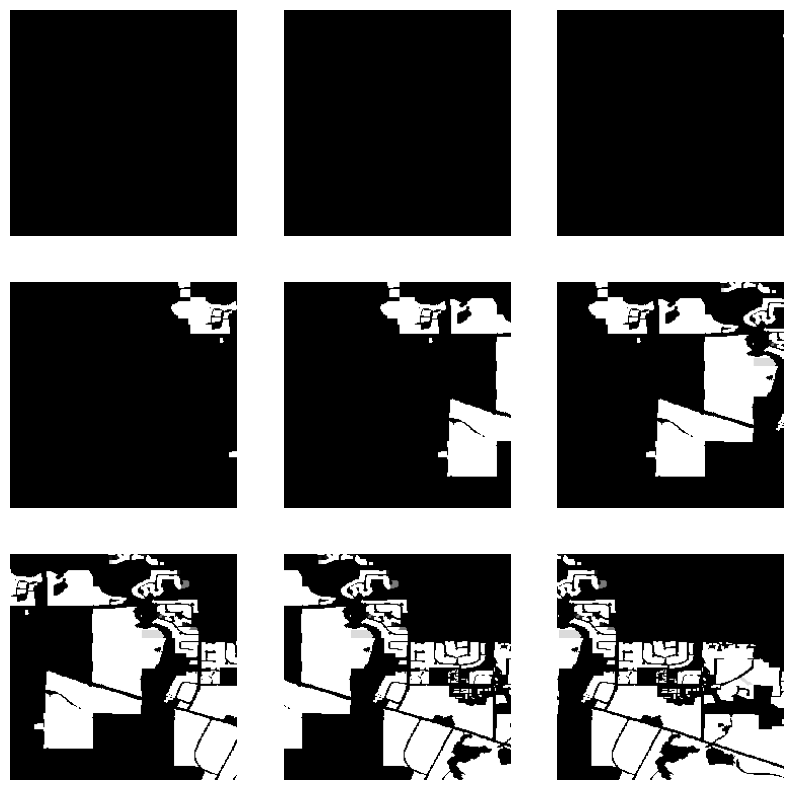

In [131]:
size = 224
step = 64


def get_patches(image, size, step):
    patches = []
    shp = (size, size)
    for i in range(0, image.shape[0], step):
        for j in range(0, image.shape[1], step):
            patch = image[i : i + size, j : j + size]
            if patch.shape != shp:
                diffx = size - patch.shape[0]
                diffY = size - patch.shape[1]
                patch = image[i - diffx : i + size, j - diffY : j + size]

            patches.append(patch)
    return patches


def plot_patches(patches, n):
    # plot first 9 patches
    fig, axes = plt.subplots(int(n**0.5), int(n**0.5), figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(patches[i], cmap="gray")
        ax.set_axis_off()


landuse_patches = get_patches(landuse, size, step)
flood_index_patches = get_patches(flood_index, size, step)
riverine_index_patches = get_patches(riverine_index, size, step)
BFE_patches = get_patches(BFE, size, step)

plot_patches(flood_index_patches, 9)
plot_patches(landuse_patches, 9)
plot_patches(riverine_index_patches, 9)
plot_patches(BFE_patches, 9)

In [132]:
# make a dataframe from the patches
df = pd.DataFrame()
df["landuse"] = landuse_patches
df["riverine_index"] = riverine_index_patches
df["BFE"] = BFE_patches
df["flood_index"] = flood_index_patches

# shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
# lenght of the dataframe
print(len(df))
# print flood_index datatype
print(df["flood_index"][0].dtype)

4977
float32


In [133]:
import torch
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        landuse = self.df.iloc[idx]["landuse"]
        riverine_index = self.df.iloc[idx]["riverine_index"]
        BFE = self.df.iloc[idx]["BFE"]
        flood_index = self.df.iloc[idx]["flood_index"]

        # reshape the data to (3, 512, 512)
        data = np.stack([landuse, riverine_index, BFE])

        # convert the data and labels to torch tensors
        data = torch.tensor(data).float()
        label = torch.tensor(flood_index).float()
        label = torch.unsqueeze(label, 0)

        return data, label


# create the custom data loader
batch_size = 16
dataset = CustomDataset(df)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [134]:
for i, batch in enumerate(dataloader):
    if i == 5:
        break
    data, label = batch
    print(data.shape)
    print(label.shape)
    print("-------------------------------------------")

torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224])
-------------------------------------------
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224])
-------------------------------------------
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224])
-------------------------------------------
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224])
-------------------------------------------
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224])
-------------------------------------------


In [137]:
import segmentation_models_pytorch as smp
from torch.nn import functional as F

# Create a TransUNet model
model = smp.Unet(
    encoder_name="mit_b0",  # specify the variant of ViT you want to use
    encoder_weights="imagenet",
    decoder_attention_type="scse",
    in_channels=3,
    classes=1,
    activation="sigmoid",
)

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [150]:
# Move the model to the device
model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 50

# Training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        # Move inputs and targets to the device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        # Compute the loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")

Epoch 1/50, Loss: 162.3176680803299
Epoch 2/50, Loss: 162.0789271891117
Epoch 3/50, Loss: 161.5152341723442
Epoch 4/50, Loss: 161.82374021410942
Epoch 5/50, Loss: 160.96229773759842
Epoch 6/50, Loss: 161.04131069779396
Epoch 7/50, Loss: 160.79111263155937
Epoch 8/50, Loss: 160.7355554997921
Epoch 9/50, Loss: 160.6094954907894
Epoch 10/50, Loss: 160.3345418870449
Epoch 11/50, Loss: 160.42656457424164
Epoch 12/50, Loss: 161.87657749652863
Epoch 13/50, Loss: 160.46760752797127
Epoch 14/50, Loss: 160.38511610031128
Epoch 15/50, Loss: 160.60131260752678
Epoch 16/50, Loss: 159.76358324289322
Epoch 17/50, Loss: 159.78015765547752
Epoch 18/50, Loss: 159.73342376947403
Epoch 19/50, Loss: 159.89294281601906
Epoch 20/50, Loss: 159.94161212444305
Epoch 21/50, Loss: 160.18161115050316
Epoch 22/50, Loss: 159.8106633424759
Epoch 23/50, Loss: 159.9908484518528
Epoch 24/50, Loss: 160.56255036592484
Epoch 25/50, Loss: 159.74636363983154
Epoch 26/50, Loss: 159.55075392127037
Epoch 27/50, Loss: 159.235997

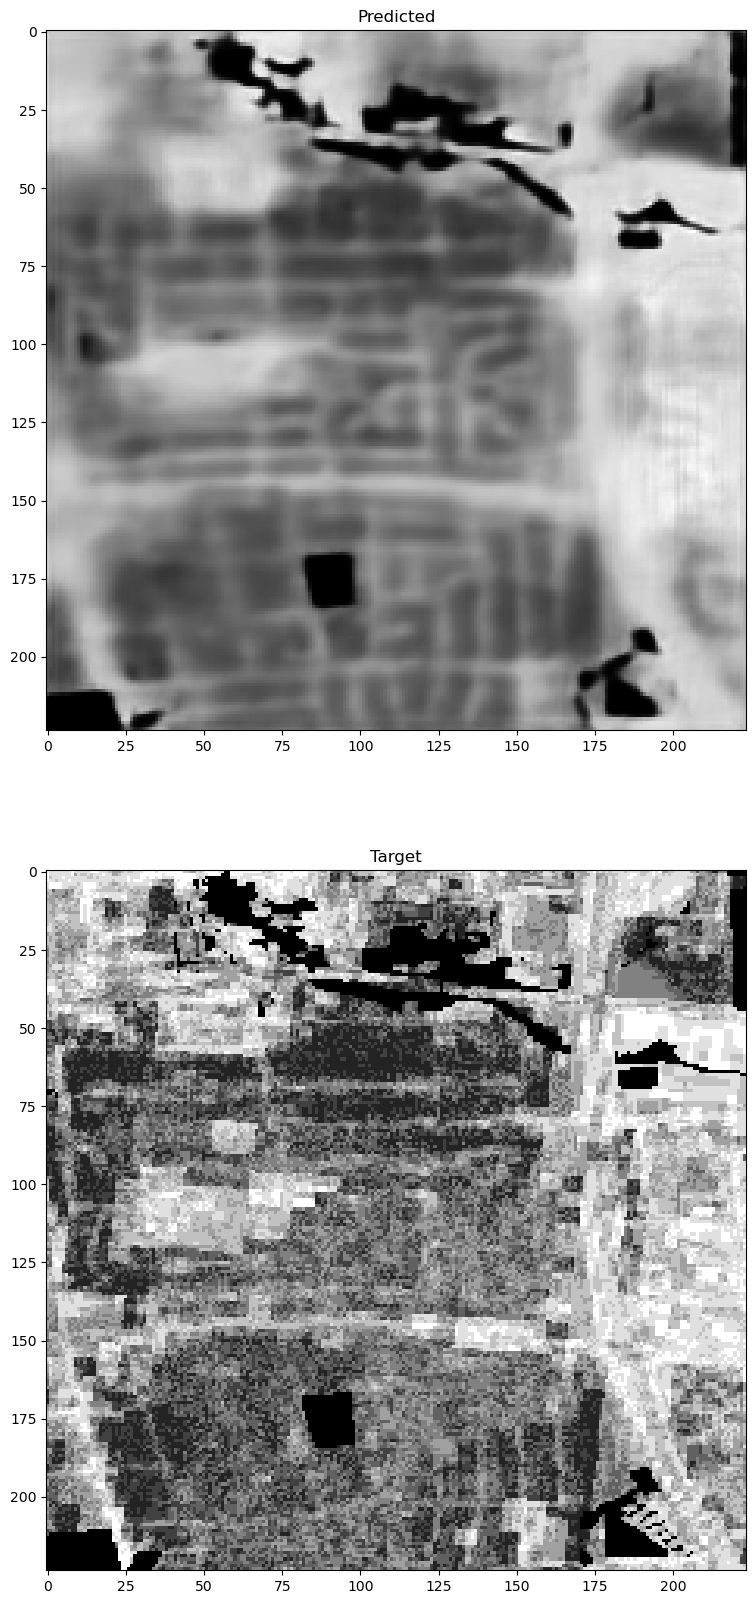

In [151]:
# get a batch of data
inputs, targets = next(iter(dataloader))
model.to(device)

# move the data to the device
inputs = inputs.to(device)
targets = targets.to(device)
# forward pass
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    outputs = outputs.cpu().numpy()
    targets = targets.cpu().numpy()

    # plot outputs and targets
    fig, axes = plt.subplots(2, 1, figsize=(10, 20))
    axes[0].imshow(outputs[0][0], cmap="gray")
    axes[0].set_title("Predicted")
    axes[1].imshow(targets[0][0], cmap="gray")
    axes[1].set_title("Target")

In [222]:
# # Now you can use the model just like any other PyTorch model
# get a batch of data
inputs, targets = next(iter(dataloader))
# move the data to the device
inputs = inputs.to(device)
targets = targets.to(device)
outputs = model(inputs)

# getting the attention scores
# forward pass
x = inputs
data = x

# fetching all the references
mixformer = model.encoder
block = mixformer.block1[0]
attention_block = block.attn
embeddings = mixformer.patch_embed1

# Getting embeddings
x, H, W = embeddings(x)
print(H, W)
print(x.shape)

# Normalize the input
x_norm = block.norm1(x)

# calculate the query, key and value
B, N, C = x.shape
q = (
    attention_block.q(x)
    .reshape(B, N, attention_block.num_heads, C // attention_block.num_heads)
    .permute(0, 2, 1, 3)
)

if attention_block.sr_ratio > 1:
    x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
    x_ = attention_block.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
    x_ = attention_block.norm(x_)
    kv = (
        attention_block.kv(x_)
        .reshape(B, -1, 2, attention_block.num_heads, C // attention_block.num_heads)
        .permute(2, 0, 3, 1, 4)
    )
else:
    kv = (
        attention_block.kv(x)
        .reshape(B, -1, 2, attention_block.num_heads, C // attention_block.num_heads)
        .permute(2, 0, 3, 1, 4)
    )
k, v = kv[0], kv[1]

# calculate the attention
attn = (q @ k.transpose(-2, -1)) * attention_block.scale
attn = attn.softmax(dim=-1)
print(attn.shape)

56 56
torch.Size([16, 3136, 32])
torch.Size([16, 1, 3136, 49])


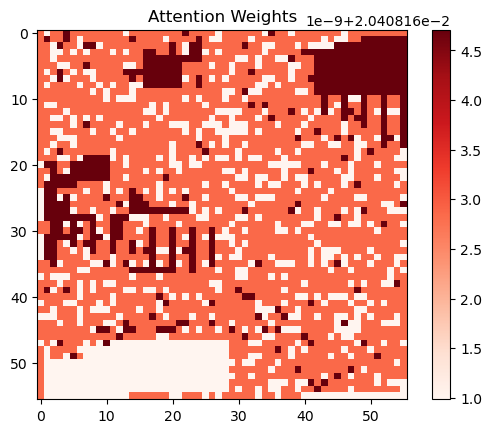

In [223]:
# Reshape the attention weights to the original height and width
attn_reshaped = attn.reshape(B, attention_block.num_heads, H, W, -1)

# Take the mean over the last dimension
attn_reshaped = attn_reshaped.mean(dim=-1)
attn_reshaped = attn_reshaped.detach().cpu().numpy()
# Visualize the attention weights for the first image in the batch
plt.imshow(attn_reshaped[0][0], cmap="Reds")
plt.title("Attention Weights")
plt.colorbar()
plt.show()

In [232]:
# Reshape the attention weights to the original height and width
attn_reshaped = attn.reshape(B, attention_block.num_heads, H, W, -1)

# Take the mean over the last dimension
attn_reshaped = attn_reshaped.mean(dim=-1)
weights_reshaped = F.interpolate(
    attn_reshaped, size=(224, 224), mode="bilinear", align_corners=False
)

# convert the data to numpy arrays
# data = data.detach().cpu().numpy()
# targets = targets.detach().cpu().numpy()
# outputs = outputs.detach().cpu().numpy()
weights_reshaped = weights_reshaped.detach().cpu().numpy()

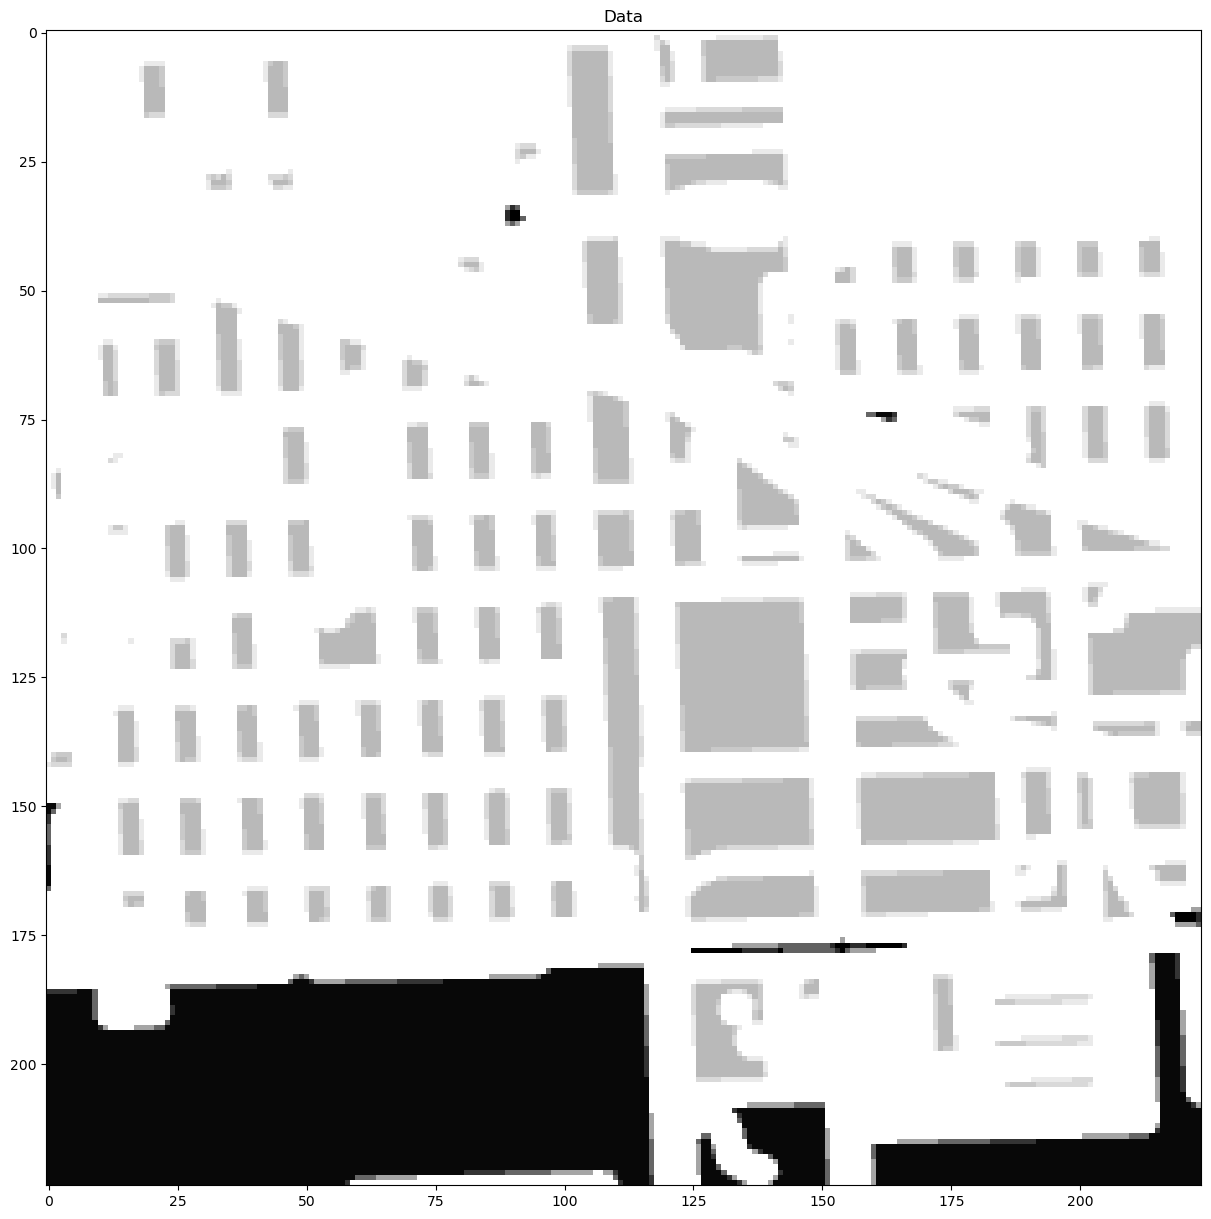

In [240]:
# plot data targets and outputs and weights reshaped
# change the figure size
fig = plt.figure(figsize=(15, 15))
plt.imshow(data[0][0], cmap="gray")
plt.title("Data")
plt.show()

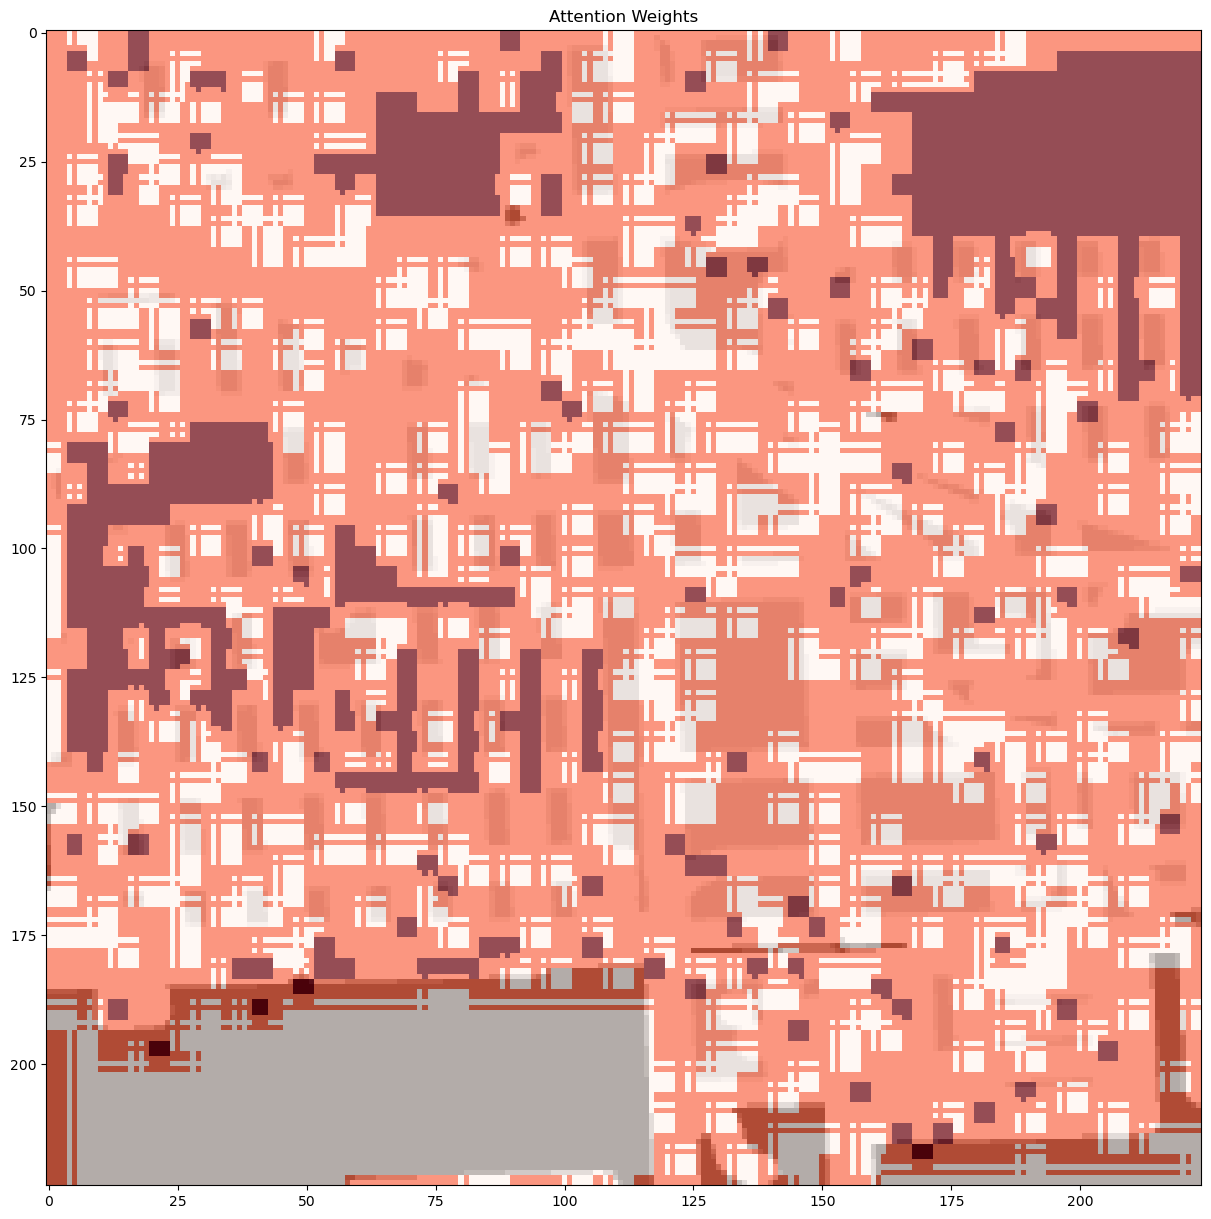

In [241]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(data[0][0], cmap="gray")
plt.imshow(weights_reshaped[0][0], cmap="Reds", alpha=0.7)
plt.title("Attention Weights")
plt.show()

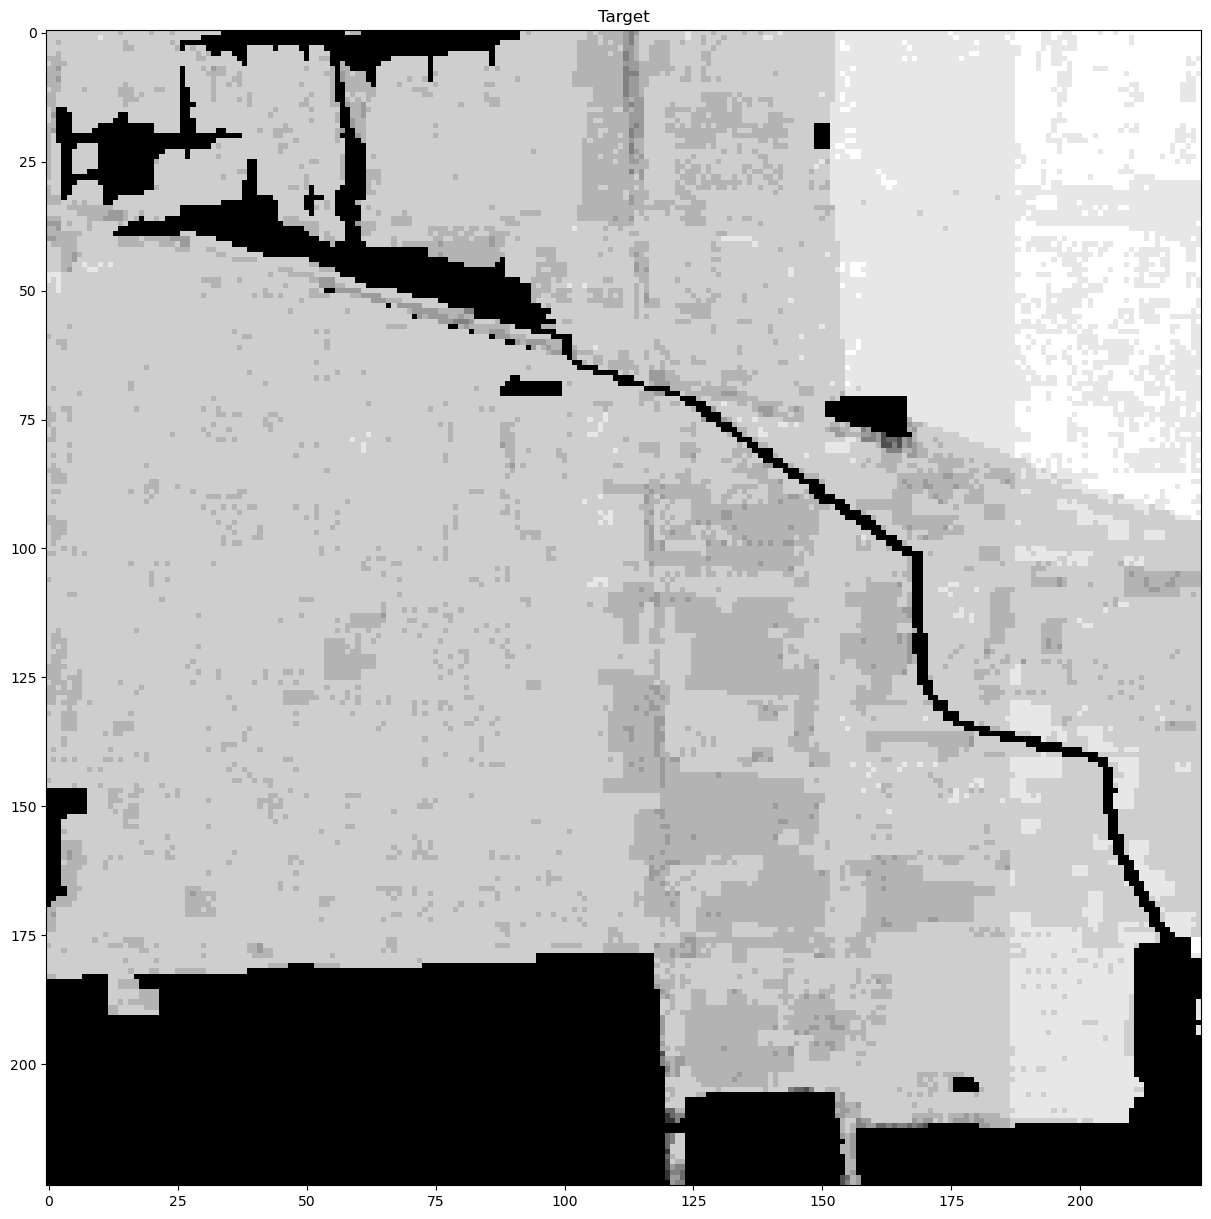

In [242]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(targets[0][0], cmap="gray")
plt.title("Target")
plt.show()

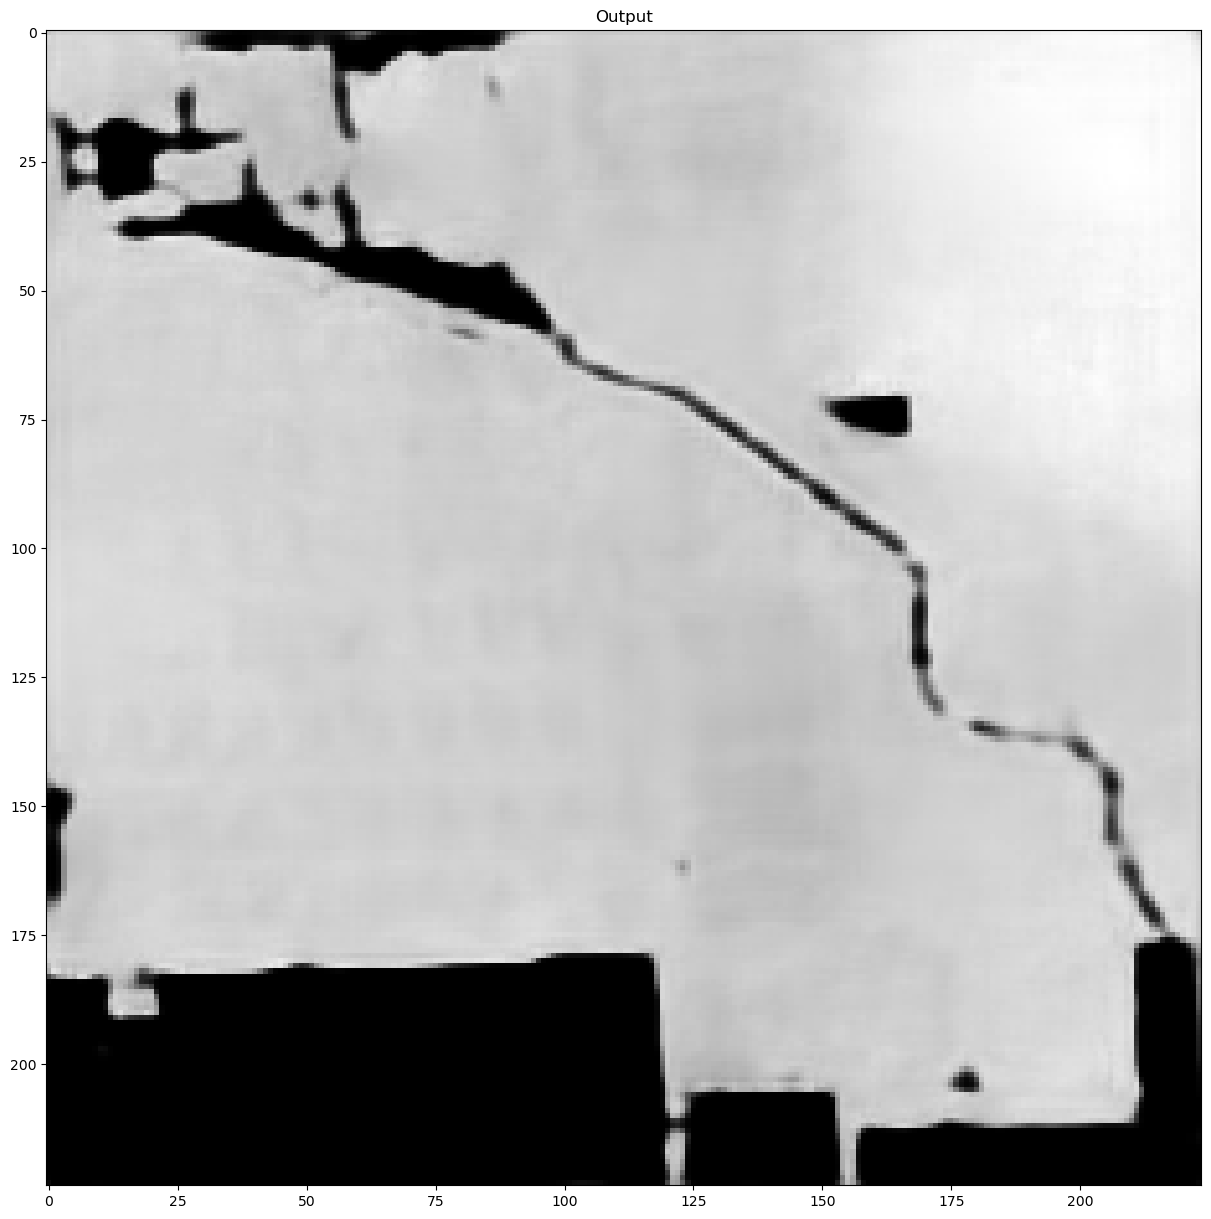

In [243]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(outputs[0][0], cmap="gray")
plt.title("Output")
plt.show()

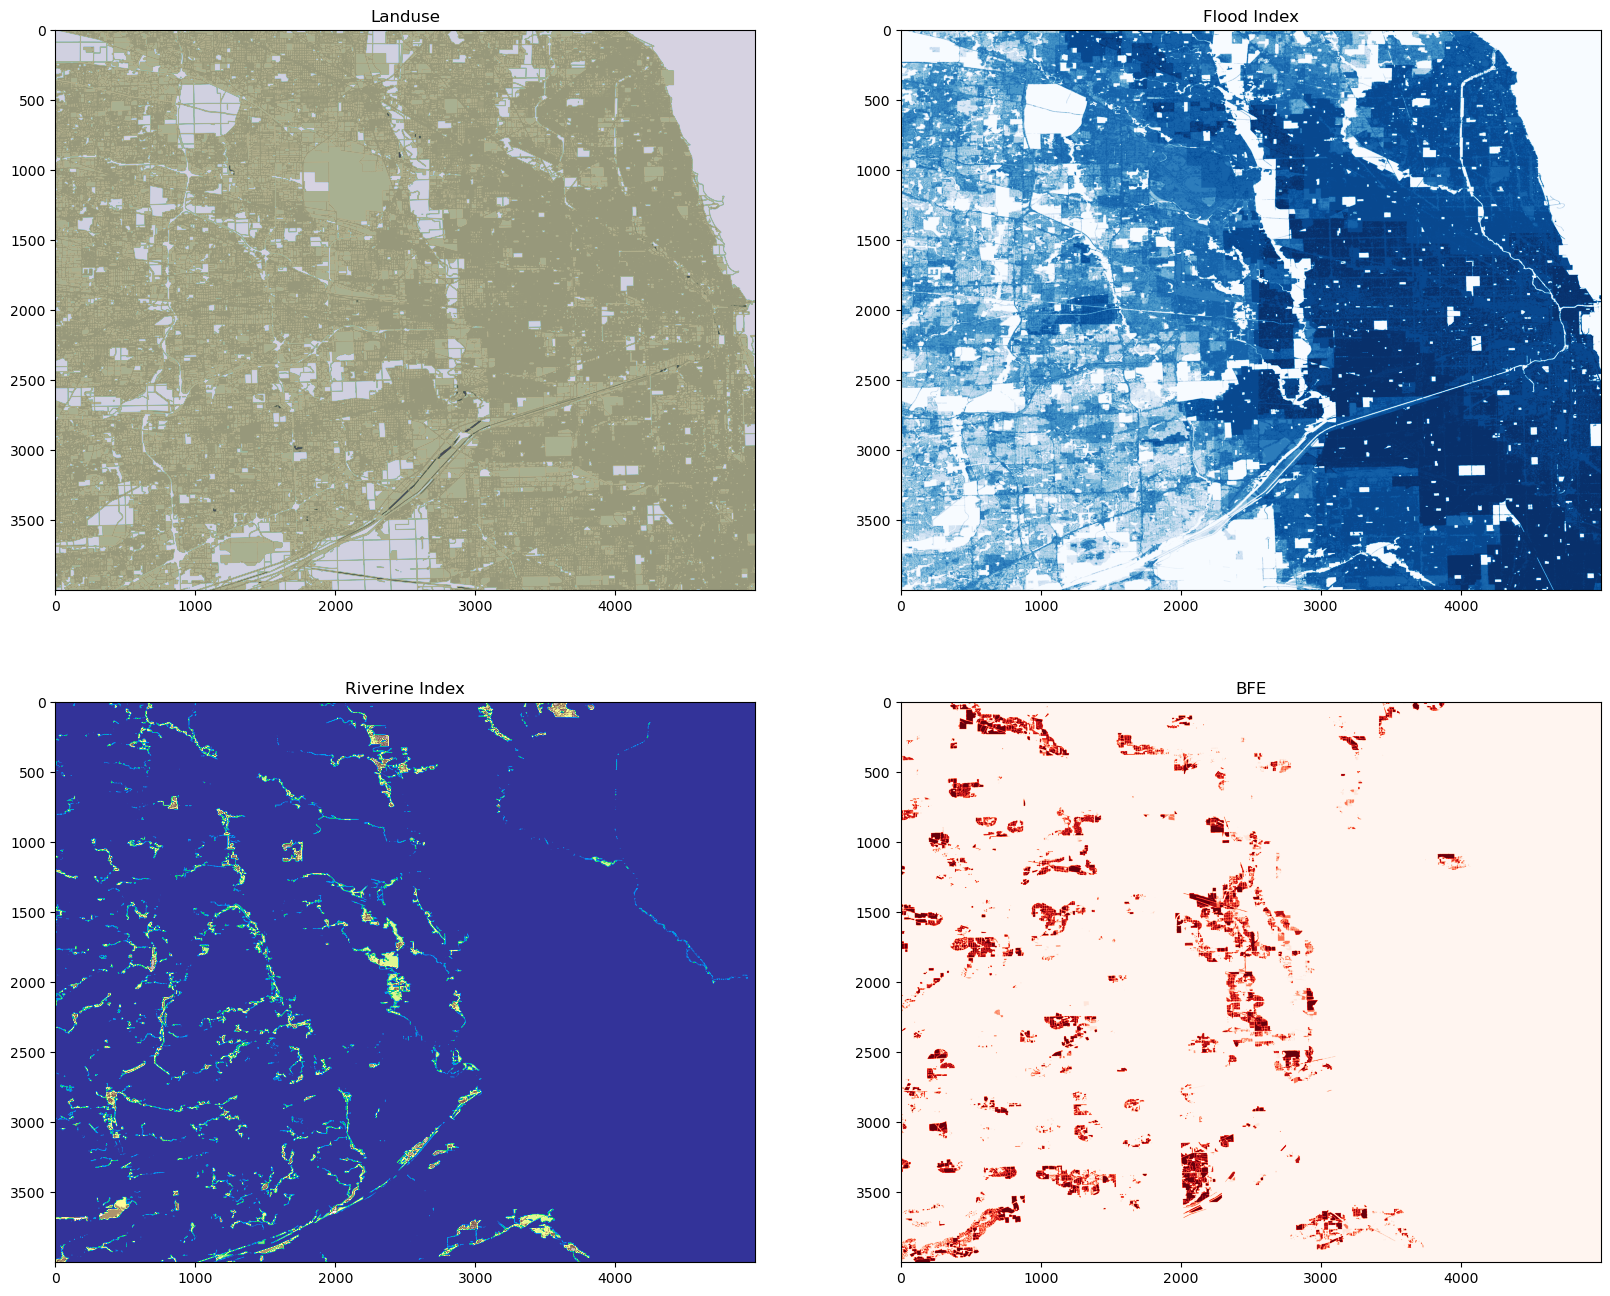

In [ ]:
# plot the single channel
# get axis object with 5 rows and 1 column
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes[0][0].imshow(landuse, cmap="copper", alpha=0.5)
axes[0][0].imshow(landuse, cmap="terrain", alpha=0.5)
axes[0][0].imshow(landuse, cmap="gray", alpha=0.7)
axes[0][0].imshow(banduse, cmap="terrain", alpha=0.2)
axes[0][0].set_title("Landuse")

axes[0][1].imshow(flood_index, cmap="Blues")
axes[0][1].set_title("Flood Index")
axes[1][0].imshow(riverine_index, cmap="terrain")
axes[1][0].set_title("Riverine Index")
axes[1][1].imshow(BFE, cmap="Reds")
axes[1][1].set_title("BFE")
plt.show()

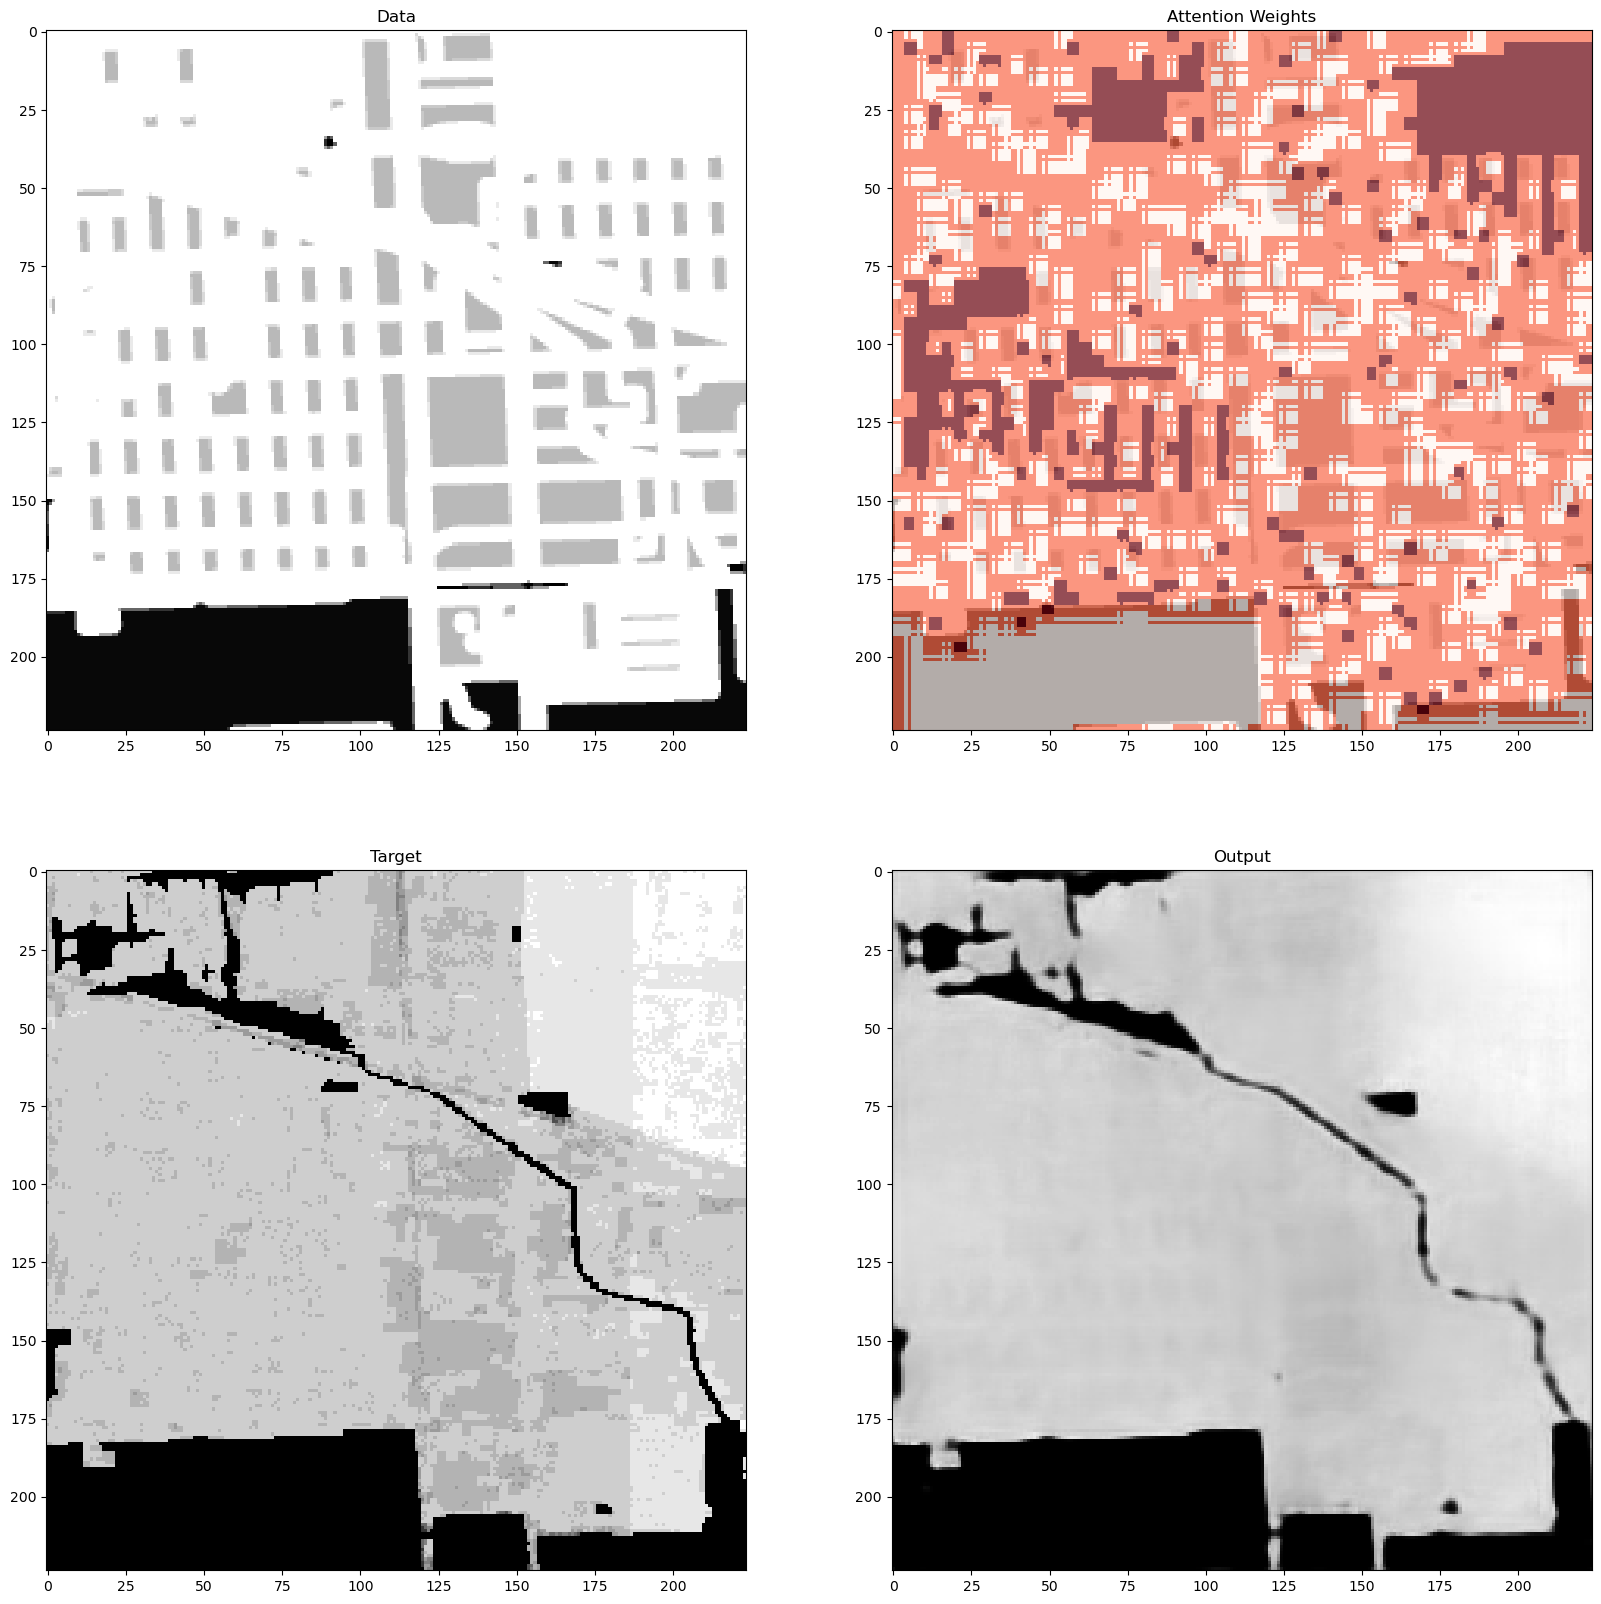

In [231]:
# plot data targets and outputs and weights reshaped
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes[0][0].imshow(data[0][0], cmap="gray")
axes[0][0].set_title("Data")

axes[0][1].imshow(data[0][0], cmap="gray")
axes[0][1].imshow(weights_reshaped[0][0], cmap="Reds", alpha=0.7)
axes[0][1].set_title("Attention Weights")

axes[1][0].imshow(targets[0][0], cmap="gray")
axes[1][0].set_title("Target")

axes[1][1].imshow(outputs[0][0], cmap="gray")
axes[1][1].set_title("Output")

plt.show()

In [226]:
# upsample the weights to match the spatial dimensions of the input image
# weights = weights.unsqueeze(0)
print(attn.shape)
weights_reshaped = F.interpolate(
    attn, size=(224, 224), mode="bilinear", align_corners=False
)

# convert the data to numpy arrays
data = data.detach().cpu().numpy()
# convert the weights to numpy arrays
weights_reshaped = weights_reshaped.detach().cpu().numpy()

# Visualize the attention weights for the first image in the batch and the image
plt.imshow(data[0][0], cmap="gray")
plt.show()
plt.imshow(weights_reshaped[0][0], cmap="hot")
plt.show()

torch.Size([16, 1, 3136, 49])


AttributeError: 'numpy.ndarray' object has no attribute 'detach'